# Introduction

**The main content of this article will present how the AlexNet Convolutional Neural Network(CNN) architecture is implemented using TensorFlow and Keras.**


**Here are some of the key learning objectives from this article:**

1. Introduction to neural network implementation with Keras and TensorFlow
2. Data preprocessing with TensorFlow
3. Training visualization with TensorBoard
4. Description of standard machine learning terms and terminologies
5. AlexNet Implementation

AlexNet CNN is probably one of the simplest methods to approach understanding deep learning concepts and techniques.

AlexNet is not a complicated architecture when it is compared with some state of the art CNN architectures that have emerged in the more recent years.

AlexNet is simple enough for beginners and intermediate deep learning practitioners to pick up some good practices on model implementation techniques.

# Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In order to reference the class names of the images during the visualization stage, a python list containing the classes is initialized with the variable name CLASS_NAMES.

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

TensorFlow provides a suite of functions and operations that enables easy data manipulation and modification through a defined input pipeline.

To be able to access these methods and procedures, it is required that we transform our dataset into an efficient data representation TensorFlow is familiar with. This is achieved using the **tf.data.Dataset API**.

More specifically, **tf.data.Dataset.from_tensor_slices** method takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation.

In [ ]:
def augment_reflect(image, label):

    #crop and reflection
    image = tf.image.resize(image, [36, 36])
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = tf.image.random_flip_left_right(image)

    #pca
    image = tf.cast(image, tf.float32) / 255.0
    reshaped_image = tf.reshape(image, [-1, 3])
    cov = tf.tensordot(tf.transpose(reshaped_image), reshaped_image, axes=1) / tf.cast(tf.shape(reshaped_image)[0], tf.float32)
    evals, evecs = tf.linalg.eigh(cov)
    alphas = tf.random.normal([3], mean=0.0, stddev=0.1)
    delta = tf.tensordot(evecs, alphas * evals, axes=1)
    image += delta
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [ ]:
# from sklearn.model_selection import train_test_split

# test_images, val_images, test_labels, val_labels = train_test_split(
#     test_images, test_labels, test_size=0.5, random_state=42)

# # train_images, train_labels: 训练数据
# # val_images, val_labels: 验证数据
# # test_images, test_labels: 测试数据

# print("Training set size:", train_images.shape[0])
# print("Validation set size:", val_images.shape[0])
# print("Test set size:", test_images.shape[0])

# train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

test_images, val_images, test_labels, val_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds = train_ds.map(augment_reflect, num_parallel_calls=tf.data.AUTOTUNE)
# print(train_ds)

# train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

print("Training set size:", train_images.shape[0])
print("Validation set size:", val_images.shape[0])
print("Test set size:", test_images.shape[0])

Training set size: 50000
Validation set size: 5000
Test set size: 5000


In [ ]:
print(val_labels)

[[2]
 [1]
 [5]
 ...
 [0]
 [3]
 [1]]


# Preprocessing

Usually, preprocessing is conducted to ensure the data utilized is within an appropriate format.

First, let’s visualize the images within the CIFAR-10 dataset.

The CIFAR-10 images have small dimensions, which makes visualization of the actual pictures a bit difficult.

In [ ]:
# plt.figure(figsize=(30,30))
# for i,(image,label) in enumerate(train_ds.take(20)):
#     #print(label)
#     ax=plt.subplot(5,5,i+1)
#     plt.imshow(image)
#     plt.title(CLASS_NAMES[label.numpy()[0]])
#     plt.axis('off')

We’ll create a function called process_images.

This function will perform all preprocessing work that we require for the data. This function is called further down the machine learning workflow.

In [ ]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image = tf.image.resize(image,(64,64))
    return image,label

# Data Pipeline

So far, we have obtained and partitioned the dataset and created a function to process the dataset. The next step is to build an input pipeline.

An input/data pipeline is described as a series of functions or methods that are called consecutively one after another.

Input pipelines are a chain of functions that either act upon the data or enforces an operation on the data flowing through the pipeline.


In [ ]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
val_ds_size=tf.data.experimental.cardinality(val_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)
print('Test size:',val_ds_size)

Train size: 50000
Test size: 5000
Test size: 5000


### For our basic input/data pipeline, we will conduct three primary operations:

#### 1. Preprocessing the data within the dataset
#### 2. Shuffle the dataset
#### 3. Batch data within the dataset

In [ ]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
val_ds=(val_ds
          .map(process_image)
          .shuffle(buffer_size=val_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

# Model Implementation

Within this section, we will implement the AlexNet CNN architecture from scratch.
Through the utilization of Keras Sequential API, we can implement consecutive neural network layers within our models that are stacked against each other.

Here are the types of layers the AlexNet CNN architecture is composed of, along with a brief description:
## Convolutional layer:
A convolution is a mathematical term that describes a dot product multiplication between two sets of elements. Within deep learning the convolution operation acts on the filters/kernels and image data array within the convolutional layer. Therefore a convolutional layer is simply a layer the houses the convolution operation that occurs between the filters and the images passed through a convolutional neural network.

## Batch Normalisation layer:

Batch Normalization is a technique that mitigates the effect of unstable gradients within a neural network through the introduction of an additional layer that performs operations on the inputs from the previous layer. The operations standardize and normalize the input values, after that the input values are transformed through scaling and shifting operations.

## MaxPooling layer:

Max pooling is a variant of sub-sampling where the maximum pixel value of pixels that fall within the receptive field of a unit within a sub-sampling layer is taken as the output. The max-pooling operation below has a window of 2x2 and slides across the input data, outputting an average of the pixels within the receptive field of the kernel.

## Flatten layer:

Takes an input shape and flattens the input image data into a one-dimensional array.

## Dense Layer:

A dense layer has an embedded number of arbitrary units/neurons within. Each neuron is a perceptron.


The code snippet represents the Keras implementation of the AlexNet CNN architecture.

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

# Training and Results

To train the network, we have to compile it.

The compilation processes involve specifying the following items:

## Loss function:

A method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the predictions and the actual values.

## Optimization Algorithm:

An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function. To reduce the loss, it is paramount the values of the weights within the network are selected appropriately.

## Learning Rate:

An integral component of a neural network implementation detail as it’s a factor value that determines the level of updates that are made to the values of the weights of the network. Learning rate is a type of hyperparameter.

We can also provide a summary of the network to have more insight into the layer composition of the network by running the **model.summary()** function.

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    # metrics=['accuracy'],
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top1_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                        

At this point, we are ready to train the network.

Training the custom AlexNet network is very simple with the Keras module enabled through TensorFlow. We simply have to call the **fit()** method and pass relevant arguments.

**Epoch**: This is a numeric value that indicates the number of time a network has been exposed to all the data points within a training dataset.

In [ ]:
history=model.fit(
    train_ds,
    epochs=80,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/80
1562/1562 [==============================] - 17s 6ms/step - loss: 1.7227 - top1_acc: 0.3785 - top5_acc: 0.8630 - val_loss: 1.4658 - val_top1_acc: 0.4700 - val_top5_acc: 0.9181
Epoch 2/80
1562/1562 [==============================] - 12s 6ms/step - loss: 1.4237 - top1_acc: 0.4904 - top5_acc: 0.9228 - val_loss: 1.3245 - val_top1_acc: 0.5306 - val_top5_acc: 0.9377
Epoch 3/80
1562/1562 [==============================] - 12s 6ms/step - loss: 1.3010 - top1_acc: 0.5376 - top5_acc: 0.9380 - val_loss: 1.2590 - val_top1_acc: 0.5547 - val_top5_acc: 0.9409
Epoch 4/80
1562/1562 [==============================] - 12s 6ms/step - loss: 1.2132 - top1_acc: 0.5726 - top5_acc: 0.9463 - val_loss: 1.1575 - val_top1_acc: 0.5925 - val_top5_acc: 0.9507
Epoch 5/80
1562/1562 [==============================] - 12s 6ms/step - loss: 1.1441 - top1_acc: 0.5960 - top5_acc: 0.9548 - val_loss: 1.0899 - val_top1_acc: 0.6154 - val_top5_acc: 0.9591
Epoch 6/80
1562/1562 [==============================] - 12s 6ms/s

In [ ]:
model.history.history.keys()

dict_keys(['loss', 'top1_acc', 'top5_acc', 'val_loss', 'val_top1_acc', 'val_top5_acc'])

Now we will visualize the training over the different epochs .

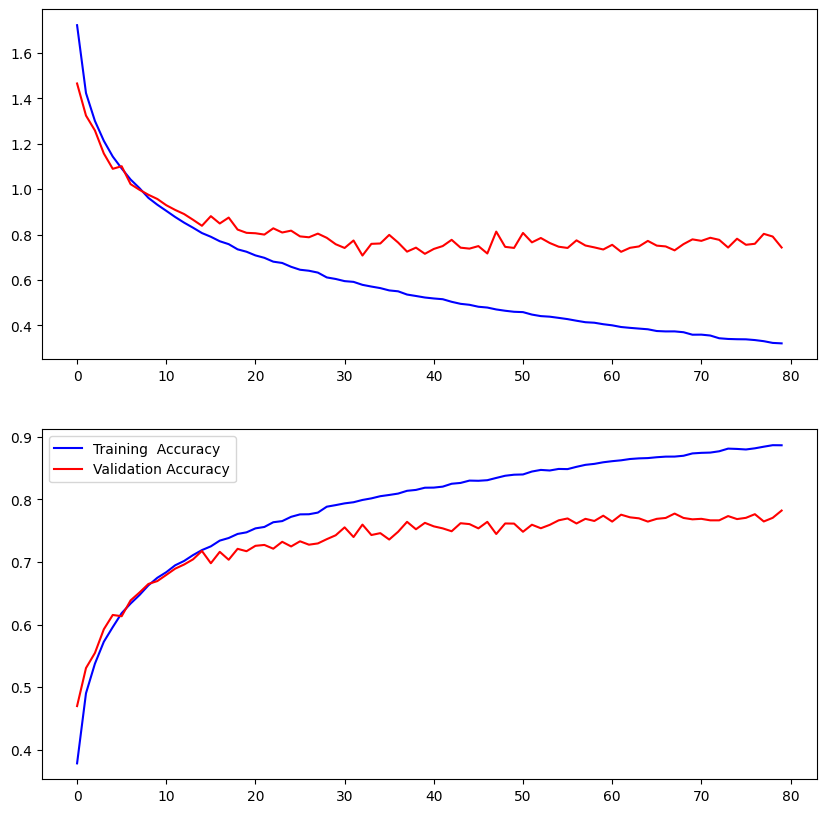

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['top1_acc'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_top1_acc'],color='r',label='Validation Accuracy')

plt.legend()

In [ ]:
val_loss, val_acc, val_top5_acc = model.evaluate(val_ds)

print("Validation Top-1 Accuracy: {:.2f}%".format(val_acc * 100))
print("Validation Top-5 Accuracy: {:.2f}%".format(val_top5_acc * 100))

156/156 [==============================] - 1s 3ms/step - loss: 0.7477 - top1_acc: 0.7760 - top5_acc: 0.9846
Validation Top-1 Accuracy: 77.60%
Validation Top-5 Accuracy: 98.46%
